In [133]:
%matplotlib inline
import rebound as r
r.reset()
import numpy as np
import matplotlib.pyplot as plt
r.status()
from IPython.html.widgets import interact, interactive
from IPython.display import display

---------------------------------
Rebound version:     	1.0.0
Build on:            	Jun 13 2015 10:38:11
Number of particles: 	0
Simulation time:     	0.000000
---------------------------------


## Simulated data:

In [258]:
data_N = 30
data_t = np.linspace(0.1,100,data_N)+0.5*np.random.rand(data_N)
data_rv = 0.500883379885605*(np.sin(2.*np.pi*data_t/50.+0.2*np.pi)+0.16*(np.random.rand(data_N)-0.5))

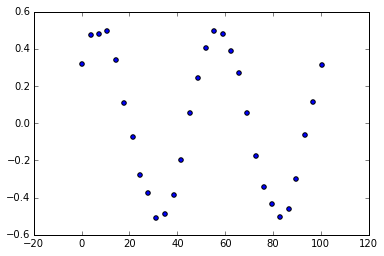

In [259]:
plt.scatter(data_t, data_rv);

## Setting up simulations

In [386]:
def simulation_rv(cart):
    r.reset()
    r.add(m=1.)
    r.add(a=cart[0],e=cart[1],anom=cart[2],omega=cart[3])
    ps = r.particles
    sim_rv = np.zeros(len(data_t))
    for i,t in enumerate(data_t):
        r.integrate(t)
        sim_rv[i] = ps[1].vx
    return sim_rv

def simulation(cart):
    r.reset()
    numvar = 4
    r.N_megnopp = numvar # 4 variation equations per particle
    r.add(m=1.)
    op = r.Particle(a=cart[0],e=cart[1],anom=cart[2],omega=cart[3])
    
    r.add(op)
    N = r.N
    
    r.init_megno(0.)
    ps = r.particles
    
    
    delta = 1e-7
    # First order
    for l in range(numvar):
        cart2 = cart.copy()
        cart2[l] += delta
        mp = r.Particle(primary=ps[0],a=cart2[0],e=np.clip(cart2[1],0.,0.9),anom=cart2[2],omega=cart2[3])

        vari = N*l+1+N
        ps[vari].x  = (mp.x  - ps[1].x  )
        ps[vari].y  = (mp.y  - ps[1].y  )
        ps[vari].z  = (mp.z  - ps[1].z  )
        ps[vari].vx = (mp.vx - ps[1].vx )
        ps[vari].vy = (mp.vy - ps[1].vy )
        ps[vari].vz = (mp.vz - ps[1].vz )
        
    _id = 0
    # Second order
    for l in range(numvar):
        for k in range(l+1):
            cart2 = cart.copy()
            cart2[l] += delta
            mp = r.Particle(primary=ps[0],a=cart2[0],e=np.clip(cart2[1],0.,0.9),anom=cart2[2],omega=cart2[3])
            cart2 = cart.copy()
            cart2[l] -= delta
            mm = r.Particle(primary=ps[0],a=cart2[0],e=np.clip(cart2[1],0.,0.9),anom=cart2[2],omega=cart2[3])
            
            vari = N*_id+1+N+numvar*N
            ps[vari].x  = .5*(mp.x  - 2.*ps[1].x  + mm.x )
            ps[vari].y  = .5*(mp.y  - 2.*ps[1].y  + mm.y )
            ps[vari].z  = .5*(mp.z  - 2.*ps[1].z  + mm.z )
            ps[vari].vx = .5*(mp.vx - 2.*ps[1].vx + mm.vx)
            ps[vari].vy = .5*(mp.vy - 2.*ps[1].vy + mm.vy)
            ps[vari].vz = .5*(mp.vz - 2.*ps[1].vz + mm.vz)
            #if _id ==0:
            #    print ps[vari].vx,ps[vari].vy
            _id +=1
    
     
    sim_rv = 0.
    sim_rvd = np.zeros(numvar)
    sim_rvd2 = np.zeros((numvar*(numvar+1)/2,4))
    for i,t in enumerate(data_t):
        r.integrate(t)
        dv = ps[1].vx-data_rv[i]
        sim_rv  += dv**2
        for k in range(numvar):
            sim_rvd[k] += (ps[k*N+1+N].vx)**2 + 2.*ps[k*N+1+N].vx*dv
        _id = 0
        for l in range(numvar):
            for k in range(l+1):
                sim_rvd2[_id][0] += np.square(ps[1].vx + 0.5*ps[l*N+N+1].vx + 0.5*ps[k*N+N+1].vx + .0000000* ps[_id*N+N*numvar+N+1].vx - data_rv[i])
                sim_rvd2[_id][1] += np.square(ps[1].vx + 0.5*ps[l*N+N+1].vx - 0.5*ps[k*N+N+1].vx - .0000000* ps[_id*N+N*numvar+N+1].vx - data_rv[i])
                sim_rvd2[_id][2] += np.square(ps[1].vx - 0.5*ps[l*N+N+1].vx + 0.5*ps[k*N+N+1].vx - .0000000* ps[_id*N+N*numvar+N+1].vx - data_rv[i])
                sim_rvd2[_id][3] += np.square(ps[1].vx - 0.5*ps[l*N+N+1].vx - 0.5*ps[k*N+N+1].vx + .0000000* ps[_id*N+N*numvar+N+1].vx - data_rv[i])
                 
                #if _id ==0 and i == len(data_t)-1:
                #    print ps[1].vx,ps[l*N+N+1].vx,ps[vari].vx
                _id += 1
    err  = np.sqrt(sim_rv)
    errd = sim_rvd/(2.*delta*err)
    errd2 = np.sqrt(sim_rvd2)
    #err = sim_rv
    #errd = sim_rvd
    #errd2 = sim_rvd2
    
    errd2m = np.zeros((numvar,numvar))
    _id = 0
    for l in range(numvar):
        for k in range(l+1):
            fdd =   (errd2[_id][0] - errd2[_id][1] - errd2[_id][2] + errd2[_id][3])
            #fdd =   (errd2[_id][0] -  errd2[_id][3])
            #if _id==0:
            #    print fdd, errd[0,0]-errd[0,1]
            #print fdd, err
            errd2m[l,k] = fdd
            errd2m[k,l] = fdd
            _id +=1
    
    #print err, -(errd-err)/delta, -(errd2-err)/(delta)
    
    return err, errd, errd2m/(4.*delta*delta)

## Visual Check

In [387]:
gamma = 0.05
a = np.array([4.5,0.6,0.,0.]) # initial parameters
sim_rvs = []             # for plotting

lastp = 1e200
lasta = a
lastgradient = []

sim_rv0 = simulation_rv(a)

N_grid = 150
a_s = np.linspace(4.0,7.0,N_grid)

errs = np.zeros(N_grid)
gradients = np.zeros(N_grid)
hessians = np.zeros(N_grid)

for i,at in enumerate(a_s):
    a[0] = at
    err, gradient, hessian = simulation(a)
    #print gradient[0], hessian[0,0]
    # print hessian
    errs[i] = err
    gradients[i] = gradient[0]
    hessians[i] = hessian[0,0]
    

        

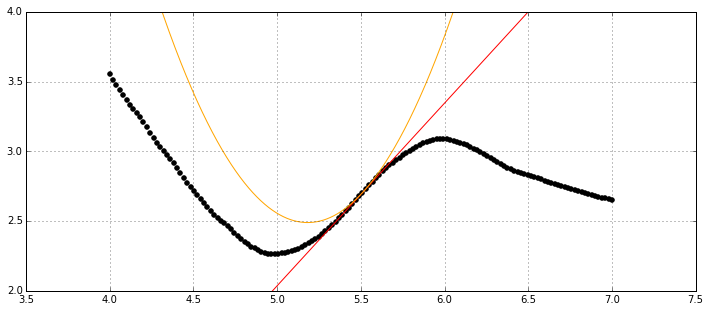

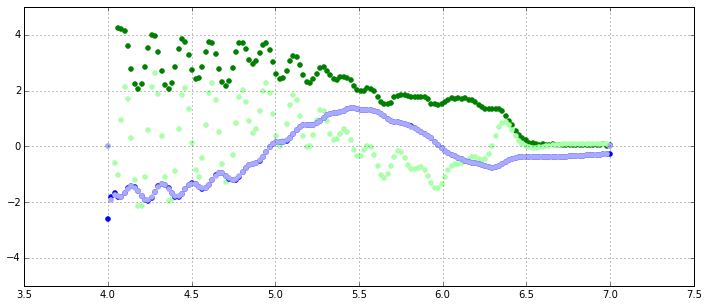

In [392]:
def widget_plot(ind):
    ind = int(ind)
    fig = plt.figure(figsize=(12,5))
    plt.ylim([2,4])
    plt.scatter(a_s, errs, color="k");
    
    def f(a,i):
        da = a - a_s[i] 
        return errs[i] + gradients[i]*da,  errs[i] + gradients[i]*da + hessians[i]*da*da
    
    a_s_fine = np.linspace(a_s[0],a_s[-1],N_grid*10)
    err_fine = np.zeros(N_grid*10)
    err_fine2 = np.zeros(N_grid*10)
    for i,a in enumerate(a_s_fine):
        err_fine[i], err_fine2[i] = f(a,ind)
    plt.plot(a_s_fine, err_fine, color="r");
    plt.plot(a_s_fine, err_fine2, color="#FFA500");
    plt.grid()


    
    fig2 = plt.figure(figsize=(12,5))
    plt.ylim([-5,5])
    gradient_direct = np.zeros(N_grid)
    hessian_direct = np.zeros(N_grid)
    for i,a in enumerate(a_s_fine):
        if i>0 and i<N_grid-1:
            gradient_direct[i] = (errs[i+1]-errs[i-1])/(a_s[i+1]-a_s[i-1])
            hessian_direct[i]  = (errs[i+1]-2.*errs[i]+errs[i-1])/((a_s[i+1]-a_s[i-1])*(a_s[i+1]-a_s[i-1]))
    
    plt.scatter(a_s, hessians, color="g");
    plt.scatter(a_s, hessian_direct, color="#aaffaa");
    plt.scatter(a_s, gradients, color="b");
    plt.scatter(a_s, gradient_direct, color="#aaaaff");
    plt.grid()


    return fig, fig2


w = interactive(widget_plot,
                ind=(0,N_grid))

display(w)

In [389]:
gradients

array([-2.61670634, -1.81931954, -1.68819281, -1.82000661, -1.82685759,
       -1.68054481, -1.50591941, -1.41862292, -1.46066636, -1.60733276,
       -1.79386393, -1.93678299, -1.96120462, -1.84261332, -1.63407453,
       -1.43868593, -1.34385702, -1.37811481, -1.51230775, -1.68041918,
       -1.80246818, -1.81466927, -1.70581316, -1.5315709 , -1.3812337 ,
       -1.32024844, -1.35685229, -1.44681804, -1.51896839, -1.50892884,
       -1.39465011, -1.21418133, -1.04432107, -0.95251707, -0.96175355,
       -1.04772816, -1.15577317, -1.22298315, -1.20322577, -1.09105959,
       -0.92756125, -0.77482768, -0.67490018, -0.62582508, -0.5888829 ,
       -0.51646115, -0.38343158, -0.20526926, -0.02936696,  0.09658933,
        0.15455021,  0.16334475,  0.16465845,  0.20083104,  0.2941129 ,
        0.43438664,  0.58355885,  0.69796694,  0.75468522,  0.76286564,
        0.75510413,  0.7681427 ,  0.82402744,  0.91931334,  1.02786945,
        1.11759452,  1.17085982,  1.19380684,  1.20863876,  1.23